Quick 4D-STEM will a bullseye aperature in abTEM

Stephanie Ribet

April 19, 2023

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import abtem
from abtem import orthogonalize_cell
from ase.build import surface
from ase.io import read

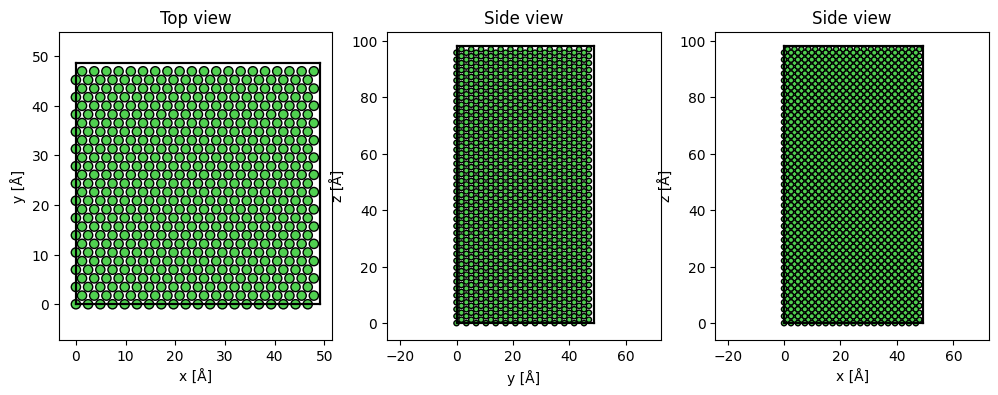

In [7]:
Ni_atoms = read("data/Ni.cif")
Ni_atoms = surface(Ni_atoms, (1, 1, 0), 4, periodic=True) 
repetitions = (10,14,10)
Ni_atoms *=repetitions

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

abtem.show_atoms(Ni_atoms, ax=ax1, title='Top view')
abtem.show_atoms(Ni_atoms, ax=ax2, plane='yz', title='Side view')
abtem.show_atoms(Ni_atoms, ax=ax3, plane='xz', title='Side view');


In [9]:
frozen_phonons = abtem.FrozenPhonons(Ni_atoms, 12, 0.1)
potential = abtem.Potential(
    frozen_phonons,
    sampling = 0.2, 
    projection = "infinite", 
    parametrization = "kirkland", 
    slice_thickness = 1,
)

In [29]:
class Bullseye_CTF(abtem.transfer.CTF):
    def __init__(self, semiangle_cutoff, energy, n_bars, *args, **kwargs):
        self._N = n_bars
        super().__init__(semiangle_cutoff,energy=energy)
        
    def evaluate(self, alpha, phi):
        CTF = self.evaluate_aperture(alpha,phi)
            
        CTF *= np.sin(2*np.pi*alpha*1000./self.semiangle_cutoff*self._N) > 0.
        
        return CTF

In [30]:
energy = 300e3
semiangle_cutoff = 3
bullseye = Bullseye_CTF(semiangle_cutoff,energy,2)

probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff, 
    extent=potential.extent,
    sampling = potential.sampling,
)

probe.ctf=bullseye

[########################################] | 100% Completed | 103.08 ms


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

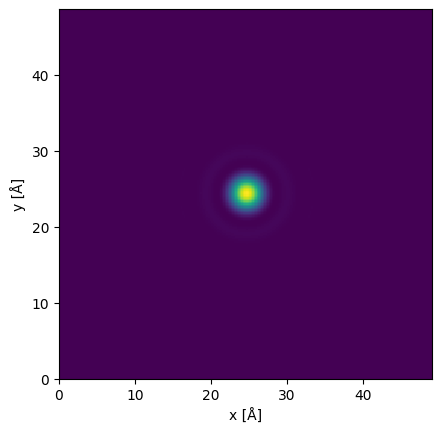

In [31]:
probe.show()

In [22]:
scan_end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = abtem.GridScan(start=[0, 0], end=scan_end, sampling=bullseye.nyquist_sampling*0.4)

detector = abtem.PixelatedDetector(max_angle='valid', resample='uniform')
measurement = probe.scan(
    potential=potential, 
    detectors=detector, 
    scan=gridscan, 
)

[########################################] | 100% Completed | 35.89 ss
[########################################] | 100% Completed | 32.37 ss


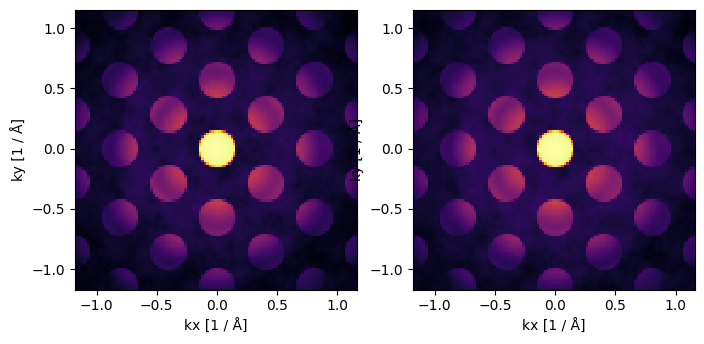

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

measurement[0, 0].show(cmap='inferno', ax=ax1, power = 0.2)
#measurement[0, 1].show(cmap='inferno', ax=ax2, power = 0.2)
    
plt.show()